### Modified Blackjack environment
- Basic implementation from: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
- Personal edits for playing until the deck reaches a certain threshold for the number of cards
- Personal edits for Complete Point count system

In [104]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
#NUM_DECKS = 1 # TODO: Move this into the environment class
#deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * NUM_DECKS

"""
def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]
"""


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

# Custom addition for counting cards
def complete_point_count_system(deck):
  score = 0
  for card in deck:
    if int(card) in [2,3,4,5,6]:
      score += 1
    elif int(card) in [10,1]:
      score -= 1
    else:
      pass
  return score

# Custom addition for counting cards
def count_cards(current_score_counted, cards_seen):
    # Count the cards. 1. keep track of the number of cards left. 2. keep track of the Complete Point count system.
    # Process num_cards_left into bins, since keeping track of each single state would explode the state space
    # TODO: Play around with this
    """
    num_cards_left = len(deck)
    if num_cards_left >= 40:
      num_cards_left = 40 # Many cards are left
    elif num_cards_left >= 30:
      num_cards_left = 30 # Medium cards are left
    else:
      num_cards_left = 20 # Few cards are left
    # TODO: This is nullifying the number of cards left to make the state space smaller. If you would like to record this, then comment out this line.
    num_cards_left = 40
    """
    num_cards_left = -1

    # Binning
    val_cards_left = current_score_counted + complete_point_count_system(cards_seen)
    """
    if val_cards_left < -5: # good for player
      val_cards_left = -5
    elif val_cards_left >= -5 and val_cards_left <= 5: # Pretty much even
      val_cards_left = 0
    else: # bad for player
      val_cards_left = 5
    """

    return val_cards_left, num_cards_left


class BlackjackEnv(gym.Env):
    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False, counting_cards=False, num_decks=1):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

        self.num_decks = num_decks
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * num_decks

        # Score for Complete Point count system
        self.counting_cards = counting_cards
        self.counting_score = 0

    def draw_card(self, np_random):
      return int(self.deck.pop())
      #return int(np_random.choice(self.deck))


    def draw_hand(self, np_random):
      return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        if self.counting_cards == True:
          counting_cards_value, _ = count_cards(self.counting_score, [self.player[0], self.player[1], self.dealer[0]])
          return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), counting_cards_value)
        else:
          return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        if self.counting_cards == True:
          # Only reshuffle when the cards get to less than 16 cards
          if len(self.deck) <= 15:
            super().reset(seed=seed)
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * self.num_decks
            random.shuffle(self.deck)
        else:
            #super().reset(seed=seed)
            pass

        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)

        return self._get_obs()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pytorch Cartpole Approach
- https://github.com/pytorch/tutorials/blob/main/intermediate_source/reinforcement_q_learning.py

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device: cuda
state example: (20, 10, False, -3)
num_episodes: 10000
Expected time with CPU: 1.0 minutes
Complete


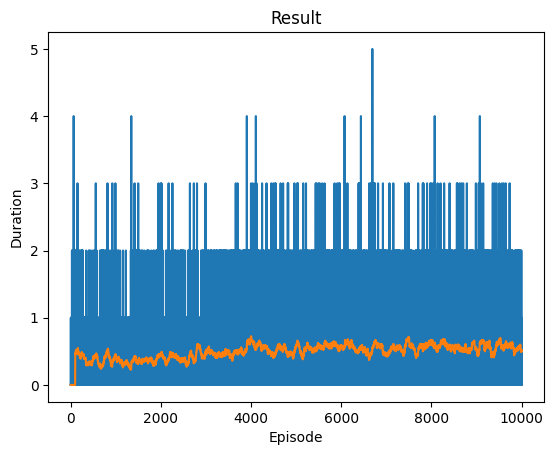

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [108]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#env = gym.make("Blackjack-v1", new_step_api=True)
COUNTING_CARDS = True
NUM_DECKS = 3
env = BlackjackEnv(counting_cards = COUNTING_CARDS, num_decks = NUM_DECKS)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
print("state example:", env.reset())
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training... How many cards are taken per episode')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()



if torch.cuda.is_available():
    #num_episodes = 60 * 10000
    num_episodes = 1 * 10000
    print("num_episodes:", num_episodes)
    print("Expected time with CPU:", num_episodes / 10000, "minutes")
else:
    # 10.000 ca. 1 minute. Scales linearly.
    num_episodes = 60 * 10000
    print("num_episodes:", num_episodes)
    print("Train time approx.:", num_episodes / 10000, "minutes")

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t)
            #plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()



In [109]:
import pandas as pd
import numpy as np
def get_optimal_strategy(dqn_network):
    index = []
    if env.counting_cards == False:
      for x in range(0,21):
          for y in range(1,11):
              index.append((x, y, True)) # Usuable Ace
              index.append((x, y, False)) # Unusuable Ace
    elif env.counting_cards == True:
      for x in range(0,21):
          for y in range(1,11):
            for counted_score in range(-10, 10):
              index.append((x, y, True, counted_score)) # Usuable Ace
              index.append((x, y, False, counted_score)) # Unusuable Ace
    index = pd.MultiIndex.from_tuples(index)
    df = pd.DataFrame(index = index, columns = ['Stand', 'Hit'])

    for ind in index:
        state = torch.tensor(np.array([ind]), dtype=torch.float32, device=device).unsqueeze(0)
        outcome = dqn_network(state)
        df.loc[ind, 'Stand'] = outcome[0][0][0]
        df.loc[ind, 'Hit'] = outcome[0][0][1]

    df['Optimal'] = df.apply(lambda x : 'Hit' if x['Hit'] >= x['Stand'] else 'Stand', axis=1)
    #df.to_csv('optimal_policy.csv')
    return df

df = get_optimal_strategy(policy_net)
df


Stand  \
0  1  True  -10  tensor(0.3348, device='cuda:0', grad_fn=<Selec...   
      False -10  tensor(0.3980, device='cuda:0', grad_fn=<Selec...   
      True  -9   tensor(0.1713, device='cuda:0', grad_fn=<Selec...   
      False -9   tensor(0.2300, device='cuda:0', grad_fn=<Selec...   
      True  -8   tensor(0.0006, device='cuda:0', grad_fn=<Selec...   
...                                                            ...   
20 10 False  7   tensor(1.1172, device='cuda:0', grad_fn=<Selec...   
      True   8   tensor(1.2759, device='cuda:0', grad_fn=<Selec...   
      False  8   tensor(1.4874, device='cuda:0', grad_fn=<Selec...   
      True   9   tensor(1.6053, device='cuda:0', grad_fn=<Selec...   
      False  9   tensor(1.7976, device='cuda:0', grad_fn=<Selec...   

                                                               Hit Optimal  
0  1  True  -10  tensor(-0.2448, device='cuda:0', grad_fn=<Sele...   Stand  
      False -10  tensor(-0.4199, device='cuda:0', grad_fn=<Sele...   Stand  
      True  -9   tensor(-0.1794, device='cuda:0', grad_fn=<Sele...   Stand  
      False -9   tensor(-0.3478, device='cuda:0', grad_fn=<Sele...   Stand  
      True  -8   tensor(-0.1134, device='cuda:0', grad_fn=<Sele...   Stand  
...                                                            ...     ...  
20 10 False  7   tensor(-0.4613, device='cuda:0', grad_fn=<Sele...   Stand  
      True   8   tensor(-0.5288, device='cuda:0', grad_fn=<Sele...   Stand  
      False  8   tensor(-0.7222, device='cuda:0', grad_fn=<Sele...   Stand  
      True   9   tensor(-0.7805, device='cuda:0', grad_fn=<Sele...   Stand  
      False  9   tensor(-0.9726, device='cuda:0', grad_fn=<Sele...   Stand  

[8400 rows x 3 columns]

### Plotting V and Q
- TODO: Where is this from?

In [110]:
# plotting
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):
    def get_Z(x, y, usable_ace):
        try:
            hit_or_stand = df.loc[x, y, usable_ace]["Optimal"]
            tensor_val = df.loc[x, y, usable_ace][hit_or_stand]
            return float(tensor_val)
        except:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        try:
            hit_or_stand = df.loc[x, y, usable_ace]["Optimal"]
            if hit_or_stand == "Hit":
              return 1
            else:
              return 0
        except:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STAND)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

# Specify here, which cards should be displayed. If counting_cards then the shape should be reduced to a single counting_score
# Expected shape: (player_hand, dealer_hand, usable_ace)
if env.counting_cards == True:
  print("Counting cards. This is the wrong cell for plotting that. Use the next one!")
  print()
else:
  plot_blackjack_values(df)
  plot_policy(df)




Counting cards. This is the wrong cell for plotting that. Use the next one!



In [111]:
if env.counting_cards == True:
  print("Counting cards. This is the wrong cell for plotting that. Use the next one!")
  print()
else:
  # Inspect points of interest
  player = 13
  dealer = 3
  usable_ace = False
  val = df.loc[player, dealer, usable_ace]
  hit_or_stand = val["Optimal"]
  print("Policy:", val["Optimal"])
  print("Hitting return:", val["Hit"])
  print("Standing return:", val["Stand"])

Counting cards. This is the wrong cell for plotting that. Use the next one!



### Plotting with counting cards

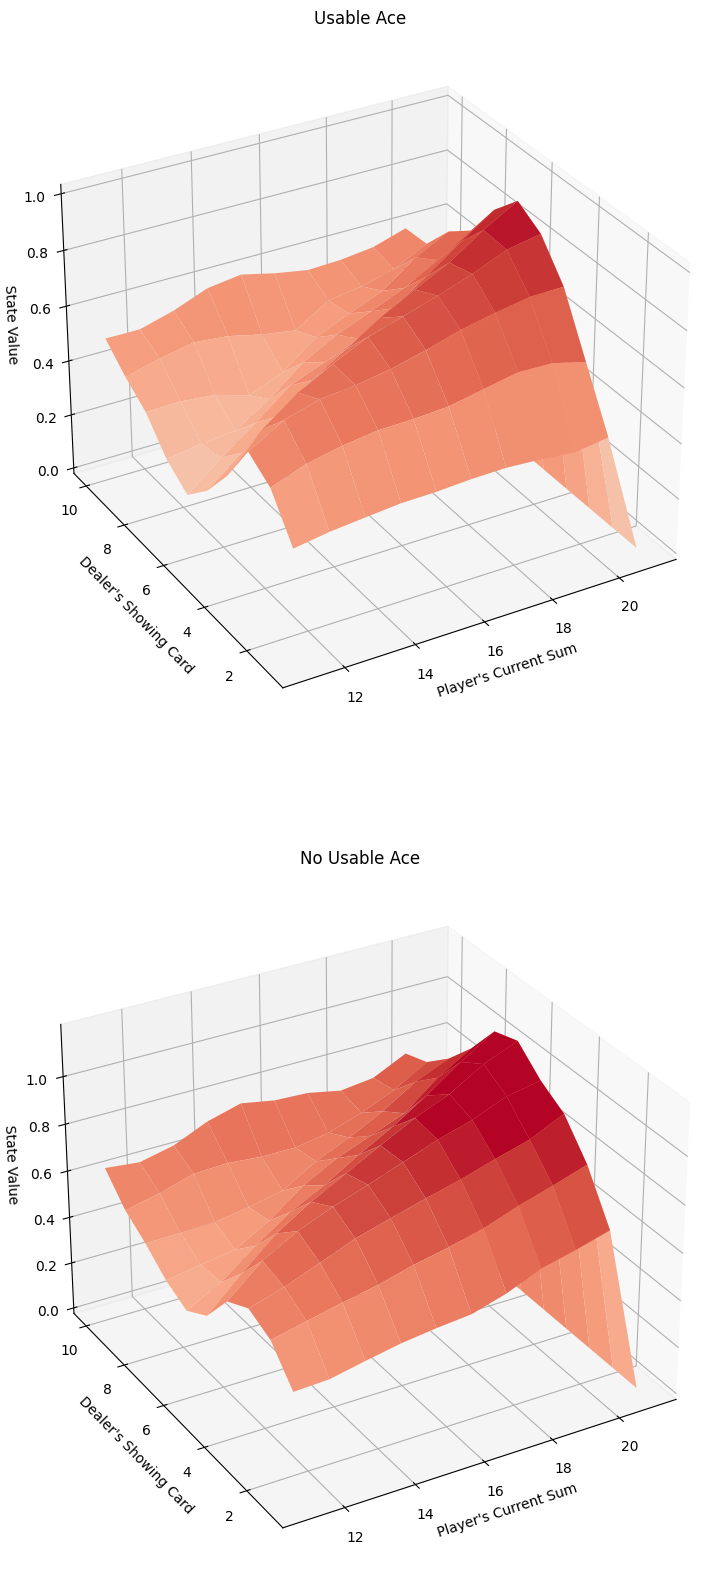

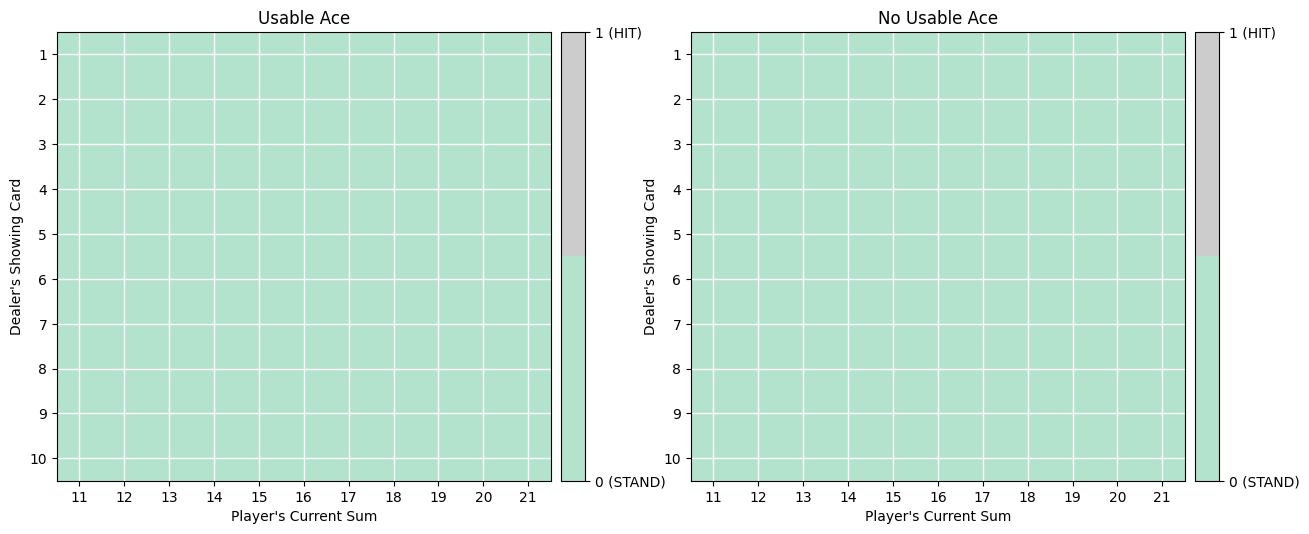

In [116]:
def plot_blackjack_values_counting_cards(V, counting_score):
    def get_Z(x, y, usable_ace):
        try:
            hit_or_stand = df.loc[x, y, usable_ace, counting_score]["Optimal"]
            tensor_val = df.loc[x, y, usable_ace, counting_score][hit_or_stand]
            return float(tensor_val)
        except:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy_counting_cards(policy, counting_score):

    def get_Z(x, y, usable_ace):
        try:
            hit_or_stand = df.loc[x, y, usable_ace, counting_score]["Optimal"]
            if hit_or_stand == "Hit":
              return 1
            else:
              return 0
        except:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STAND)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

if env.counting_cards == True:
  COUNTING_SCORE = 6
  plot_blackjack_values_counting_cards(df, COUNTING_SCORE)
  plot_policy_counting_cards(df, COUNTING_SCORE)
else:
  print("Didn't count cards. Use the previous cell for plotting that.")